In [1]:
import os, random
import numpy as np
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.metrics import *
from sklearn.model_selection import *

import matplotlib.pyplot as plt
import seaborn as sns

print("Tensorflow :", tf.__version__)

Tensorflow : 2.6.0


In [2]:
SEED = 2021
SIZE = (256, 256)
BATCH_SIZE = 32

In [3]:
train = pd.read_csv("../input/bdc-2021/train.csv")
test = pd.read_csv("../input/bdc-2021/submission.csv")
train.head()

nomor  jenis kelamin  usia
0      1              0    27
1      2              1    24
2      3              0    29
3      4              1    23
4      5              0    20

In [4]:
images = []
labels = []
test_images = []

TRAIN_DIR = "../input/bdc-2021/Training"
TEST_DIR = "../input/bdc-2021/Testing"

for no, label in train[["nomor", "jenis kelamin"]].values:
    TEMP_DIR = os.path.join(TRAIN_DIR, str(no))
    for file in os.listdir(TEMP_DIR):
        file_dir = os.path.join(TEMP_DIR, file)
        if ".ini" not in file_dir:
            images.append(file_dir)
            labels.append(label)

for no in test.id.values:
    file_dir = os.path.join(TEST_DIR, f"{no}.jpg")
    if os.path.isfile(file_dir):
        test_images.append(file_dir)
    else:
        test_images.append(None)
        print(file_dir)

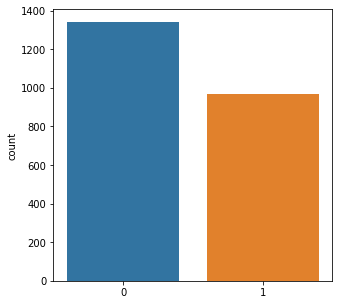

In [5]:
plt.figure(figsize=(5, 5))
sns.countplot(x=labels)
plt.show()

In [6]:
def read(path):
    """
    Read data gambar
    """
    img = Image.open(path)
    return img

def show_images(list_dir, label = None, load_image = read, seed = SEED):
    """
    Menampilkan Gambar Secara acak sebanyak 5 buah.
    """
    random.seed(seed)
    unique = ["init"]
    if label:
        unique = list(set(label))
    fig, axes = plt.subplots(len(unique), 5, figsize = (20, 5 * len(unique)))
    for i in range(len(unique)):
        if i == 0 and unique[i] == "init":
            data = random.sample(list_dir, 5)
        else:
            data = random.sample([x for x in zip(list_dir, label) if x[1] == unique[i]], 5)
        for j in range(5):
            if unique[0] != "init":
                img = load_image(data[j][0])
                axes[i, j].imshow(img)
                axes[i, j].set_title(f'Label : {data[j][1]}', fontsize = 14)
                axes[i, j].axis('off')
            else:
                img = load_image(data[j])
                axes[j].imshow(img)
                axes[j].axis('off')
    fig.tight_layout()
    plt.show()

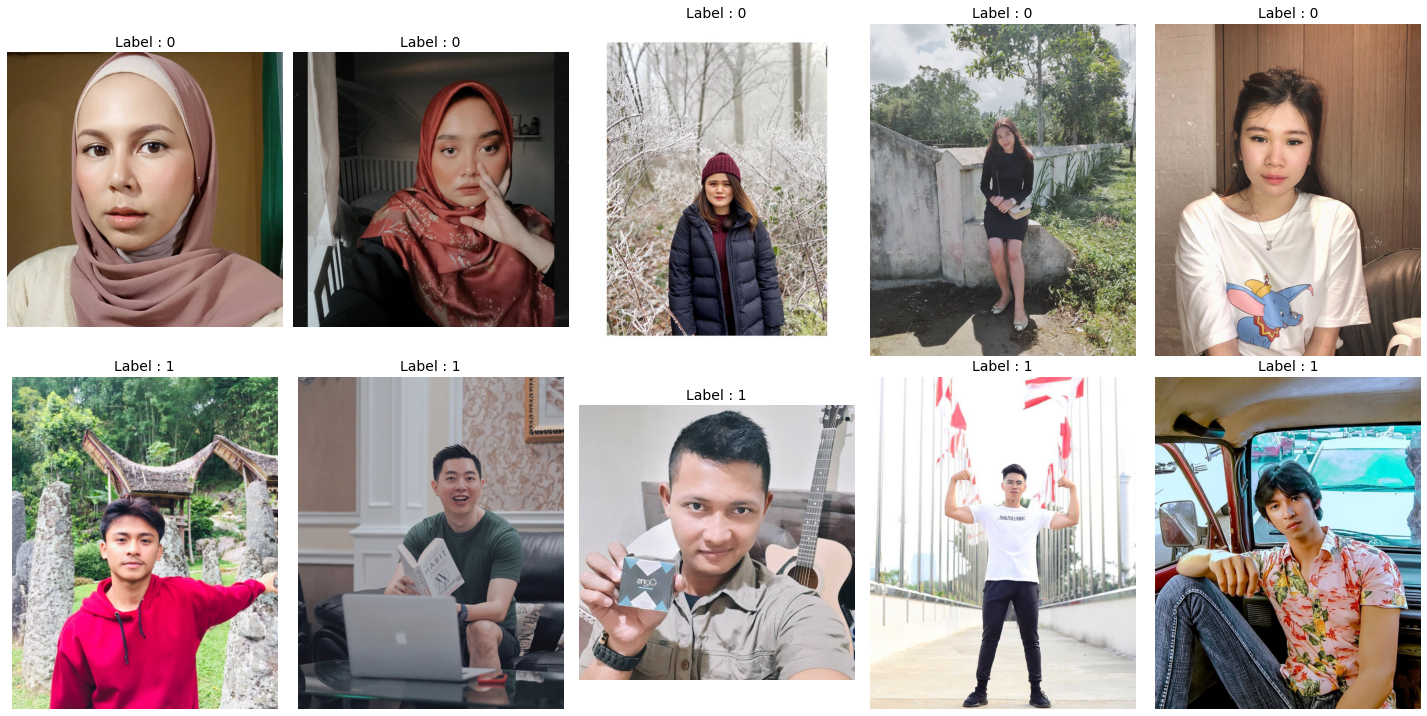

In [7]:
show_images(images, labels)

In [8]:
def load_and_preprocess_image(path: str, size = SIZE):
    """
    Load & Preprocess data gambar
    """
    image = img_to_array(load_img(path))
    img = tf.convert_to_tensor(image, dtype=tf.float32)
    shapes = tf.shape(img)
    h, w = shapes[-3], shapes[-2]
    dim = tf.minimum(h, w)
    img = tf.image.resize_with_crop_or_pad(img, dim, dim)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img.numpy()

2021-10-26 20:50:13.652347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 20:50:13.732696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 20:50:13.733399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 20:50:13.736324: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

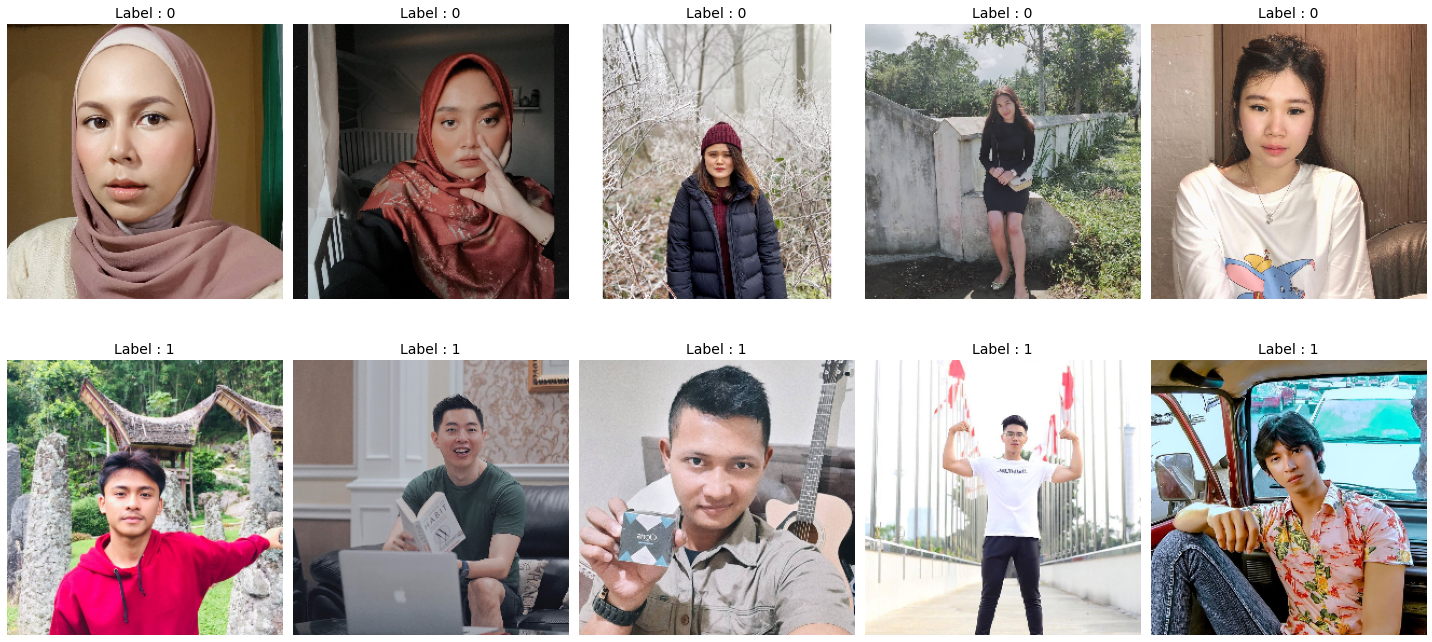

In [9]:
show_images(images, labels, load_image = load_and_preprocess_image)

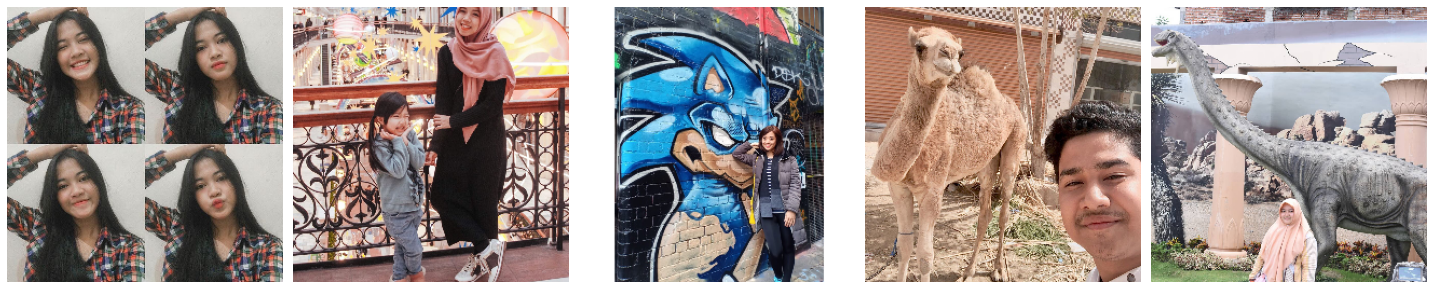

In [10]:
# TO BE DELETED
rancu = [
    "0db77c32-10cc-4595-84e6-90c37678f518",
    "4870d63f-c2bb-4798-8e96-3bc9e6d0d8f4",
    "3d6171d7-d21c-45fd-9f68-7945a79f4737",
    "5e2e3f87-ce6f-4fbe-a6c9-c058796858dc",
    "0bf9b43e-fd13-4ef9-b423-5a3d43fec20f",
]
rancu = [os.path.join(TEST_DIR, f"{x}.jpg") for x in rancu]
show_images(rancu, load_image = load_and_preprocess_image, seed=15)

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(images, labels, test_size=0.15, 
                                                      stratify=labels, random_state=SEED)

In [12]:
def decode_image(filename, label=None, image_size=SIZE):
    """
    Decode Image from String Path Tensor
    """
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0

    if label is None: # if test
        shapes = tf.shape(image)
        h, w = shapes[-3], shapes[-2]
        dim = tf.minimum(h, w)
        image = tf.image.resize_with_crop_or_pad(image, dim, dim)
        image = tf.image.resize(image, image_size)
        return image
    else:
        image = tf.image.resize(image, image_size)
        return image, label

In [13]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .map(decode_image)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
)

# TF Valid Dataset
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .map(decode_image)
    .batch(BATCH_SIZE)
    .cache()
)

# TF Test Dataset
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_images))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [14]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.applications.resnet50.ResNet50(
        include_top=False, weights=None, input_shape = (256,256,3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(5e-4)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 25,686,913
Trainable params: 25,633,793
Non-trainable params: 53,120
_______________________________________

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('Resnet50_best_model.h5', monitor='val_loss', 
                                                save_best_only=True, save_weights_only=True, 
                                                mode='min')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset, 
          steps_per_epoch=len(x_train) // BATCH_SIZE,
          callbacks = [checkpoint])

Epoch 1/50


2021-10-26 20:50:24.970829: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-26 20:50:36.087890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 601 of 1024
2021-10-26 20:50:43.018416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2021-10-26 20:50:44.201614: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


61/61 [==============================] - 62s 551ms/step - loss: 1.9304 - accuracy: 0.5451 - val_loss: 29.1613 - val_accuracy: 0.5793
Epoch 2/50
61/61 [==============================] - 14s 222ms/step - loss: 1.5097 - accuracy: 0.5738 - val_loss: 1.2127 - val_accuracy: 0.5793
Epoch 3/50
61/61 [==============================] - 14s 222ms/step - loss: 1.2834 - accuracy: 0.5671 - val_loss: 1.1600 - val_accuracy: 0.5706
Epoch 4/50
61/61 [==============================] - 14s 222ms/step - loss: 1.1615 - accuracy: 0.5815 - val_loss: 1.0936 - val_accuracy: 0.5793
Epoch 5/50
61/61 [==============================] - 14s 223ms/step - loss: 1.0618 - accuracy: 0.6209 - val_loss: 1.1033 - val_accuracy: 0.6081
Epoch 6/50
61/61 [==============================] - 14s 222ms/step - loss: 1.0086 - accuracy: 0.6153 - val_loss: 1.0260 - val_accuracy: 0.5706
Epoch 7/50
61/61 [==============================] - 14s 222ms/step - loss: 0.9716 - accuracy: 0.6363 - val_loss: 0.9410 - val_accuracy: 0.6427
Epoch 8/5

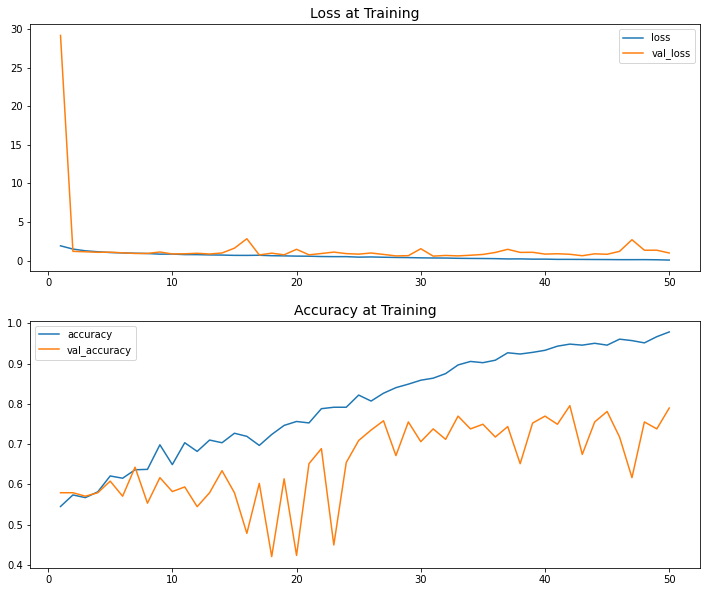

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 10))
ax1.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label = 'loss')
ax1.plot(range(1, len(history.history['loss']) + 1), history.history['val_loss'], label = 'val_loss')
ax1.set_title('Loss at Training', fontsize = 14)
ax1.legend()
ax2.plot(range(1, len(history.history['loss']) + 1), history.history['accuracy'], label = 'accuracy')
ax2.plot(range(1, len(history.history['loss']) + 1), history.history['val_accuracy'], label = 'val_accuracy')
ax2.set_title('Accuracy at Training', fontsize = 14)
ax2.legend()
fig.show()

In [17]:
model.load_weights('Resnet50_best_model.h5')

In [18]:
val_pred_classes = np.array(model.predict(valid_dataset).flatten() >= .5, dtype = 'int')
print(f'Accuracy Valid Data : {accuracy_score(y_valid, val_pred_classes)}')
print(f'F1 Score Valid Data : {f1_score(y_valid, val_pred_classes)}')

Accuracy Valid Data : 0.7377521613832853
F1 Score Valid Data : 0.7217125382262998


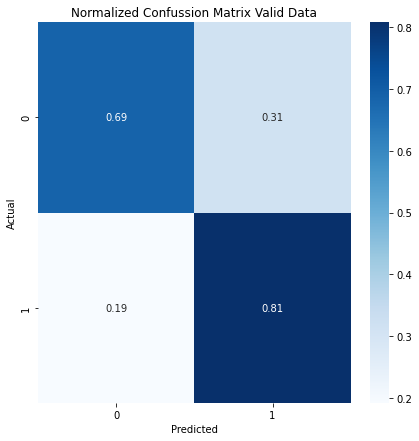

In [19]:
plt.figure(figsize = (7, 7))
sns.heatmap(confusion_matrix(y_valid, val_pred_classes, normalize = 'true'),
            annot=True, cmap=plt.cm.Blues)
plt.title('Normalized Confussion Matrix Valid Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
test['jenis kelamin'] = np.array(model.predict(test_dataset).flatten() >= .5, dtype = 'int')
test.head()

id  jenis kelamin
0  005093b2-8c4b-4ed7-91c3-f5f4d50f8d27              0
1  0052554e-069e-4c43-beb0-0885e8f7684e              1
2  0092b954-1143-4a95-a17b-1edfa6af3b01              0
3  009fc28b-fe9b-441d-b8a2-ea8b7ae6ca16              1
4  00d0e306-06fe-45d8-ae6c-6f83ab8f7810              1

In [21]:
test.to_csv("submission.csv", index=False)